# Modeling and Simulation in Python

Chapter 5: Design

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the function defined in the `modsim` module.

In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

In [2]:
init = StateVector([])
init['S'] = 89
init['I'] = 1
init['R'] = 0
init

S    89
I     1
R     0
dtype: int64

In [3]:
init = StateVector([89, 1, 0], index=['S', 'I', 'R'])
init

S    89
I     1
R     0
dtype: int64

In [4]:
init /= np.sum(init)
init

S    0.988889
I    0.011111
R    0.000000
dtype: float64

In [5]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = StateVector([89, 1, 0], index=['S', 'I', 'R'])
    init /= np.sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [6]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

sir = make_system(beta, gamma)

In [7]:
def update1(system, state):
    """Update the SIR model.
    
    system: System object
    state: StateVector (s, i, r)
    
    returns: StateVector (sir)
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return StateVector([s, i, r], index=state.index)

In [8]:
state = update1(sir, init)
state

S    0.985226
I    0.011996
R    0.002778
dtype: float64

In [9]:
def run_model(system, update_func):
    state = system.init
    for i in range(system.t0, system.t_end):
        state = update_func(system, state)
    return state

In [10]:
run_model(sir, update1)

S    0.520568
I    0.000666
R    0.478766
dtype: float64

### Using Series objects

In [11]:
def run_model(system, update_func):
    S = TimeSeries([])
    I = TimeSeries([])
    R = TimeSeries([])

    state = system.init
    S[0], I[0], R[0] = state
    
    for i in range(sir.t0, sir.t_end):
        state = update_func(system, state)
        S[i+1], I[i+1], R[i+1] = state
    
    system.S = S
    system.I = I
    system.R = R

In [12]:
sir = make_system(beta, gamma)
run_model(sir, update1)

In [13]:
def plot_results(S, I, R):
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Resistant')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

Saving figure to file chap05-fig01.pdf


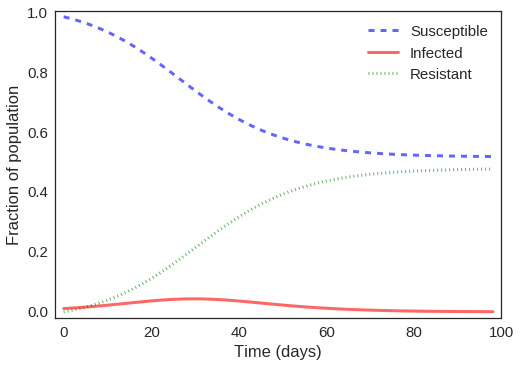

In [14]:
plot_results(sir.S, sir.I, sir.R)
savefig('chap05-fig01.pdf')

### Using a DataFrame

In [15]:
def run_model(system, update_func):
    df = DataFrame(columns=['S', 'I', 'R'])
    df.loc[system.t0] = system.init
    
    for i in range(system.t0, system.t_end):
        df.loc[i+1] = update_func(system, df.loc[i])
    
    system.results = df

In [16]:
sir = make_system(beta, gamma)
run_model(sir, update1)
sir.results.head()

,S,I,R
0,0.988889,0.011111,0.000000
1,0.985226,0.011996,0.002778
2,0.981287,0.012936,0.005777
3,0.977055,0.013934,0.009011
4,0.972517,0.014988,0.012494


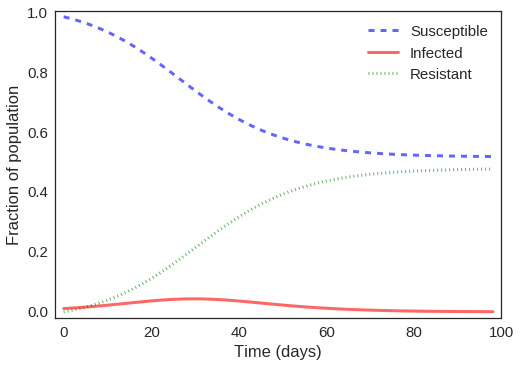

In [17]:
df = sir.results
plot_results(df.S, df.I, df.R)

### Metrics

In [18]:
def calc_total_infected(system):
    df = system.results
    return df.S[system.t0] - df.S[system.t_end]

In [19]:
sir.beta, calc_total_infected(sir)

(0.3333333333333333, 0.46832081102878098)

In [20]:
sir.beta = 0.333
sir.gamma = 0.25
run_model(sir, update1)
print(sir.beta, sir.gamma, calc_total_infected(sir))

0.333 0.25 0.467162931836


In [21]:
beta_array = linspace(0.1, 0.9, 11)
gamma = 0.25

In [22]:
for beta in beta_array:
    sir = make_system(beta, gamma)
    run_model(sir, update1)
    print(sir.beta, calc_total_infected(sir))

0.1 0.00723090166498
0.18 0.0262722567457
0.26 0.160575485321
0.34 0.490862856866
0.42 0.689867847411
0.5 0.804506112463
0.58 0.873610307851
0.66 0.916554007142
0.74 0.943729262152
0.82 0.961060480958
0.9 0.972099315633


**Exercise:** Write functions that take a `System` object as a parameter and compute the other metrics mentioned in the book:

1.  The fraction of students who are sick at the peak of the outbreak.

2.  The day the outbreak peaks.

3.  The fraction of students who are sick at the end of the semester.

Hint:  If you have a `TimeSeries` called `I`, you can compute the largest value of the series like this:

    I.max()

And the index of the largest value like this:

    I.argmax()

You can read about these functions in the [`Series` documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html).

In [23]:
# Solution

def fraction_sick_at_peak(system):
    df = system.results
    return df.I.max()

In [24]:
# Solution

fraction_sick_at_peak(sir)

0.41638286028612864

In [25]:
# Solution

def time_of_peak(system):
    df = system.results
    return df.I.argmax()

In [26]:
# Solution

time_of_peak(sir)

10

In [27]:
# Solution

def sick_at_end(system):
    df = system.results
    return df.I[system.t_end]

In [28]:
# Solution

sick_at_end(sir)

4.3812814687780321e-11

### What if?

In [29]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

sir = make_system(beta, gamma)
sir.beta, sir.gamma

(0.3333333333333333, 0.25)

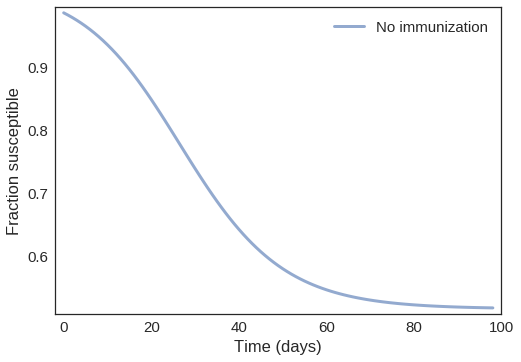

In [30]:
run_model(sir, update1)
plot(sir.results.S, '-', label='No immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

In [31]:
calc_total_infected(sir)

0.46832081102878098

In [32]:
def add_immunization(system, fraction):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= fraction
    system.init.R += fraction

Saving figure to file chap05-fig02.pdf


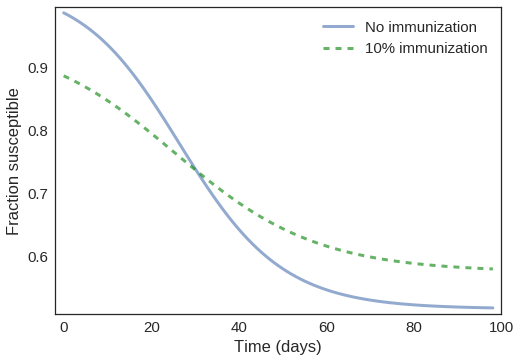

In [33]:
sir2 = make_system(beta, gamma)
add_immunization(sir2, 0.1)
run_model(sir2, update1)
plot(sir.results.S, '-', label='No immunization')
plot(sir2.results.S, 'g--', label='10% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

savefig('chap05-fig02.pdf')

In [34]:
calc_total_infected(sir2)

0.30650802853979753

In [35]:
immunize_array = linspace(0, 1, 11)
for fraction in immunize_array:
    sir = make_system(beta, gamma)
    add_immunization(sir, fraction)
    run_model(sir, update1)
    print(fraction, calc_total_infected(sir))

0.0 0.468320811029
0.1 0.30650802854
0.2 0.161365457006
0.3 0.0728155898425
0.4 0.035520216753
0.5 0.0196887157825
0.6 0.0116220579983
0.7 0.00683873780062
0.8 0.00369649625371
0.9 0.00148153267227
1.0 -0.000161212109412


In [36]:
def sweep_immunity(immunize_array):
    sweep = Sweep([])
    for fraction in immunize_array:
        sir = make_system(beta, gamma)
        immunize(sir, fraction)
        run_model(sir, update1)
        sweep[fraction] = calc_total_infected(sir)
    return sweep

In [37]:
immunize_array = linspace(0, 1, 21)
infected_sweep = sweep_immunity(immunize_array)

NameError: name 'immunize' is not defined

In [ ]:
plot(infected_sweep)

decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=False)

savefig('chap05-fig03.pdf')

### Hand washing

In [ ]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

sir = make_system(beta, gamma)
sir.beta, sir.gamma

In [ ]:
def logistic(x, a, b, c=0):
    exponent = -a * (x-b)
    denom = 1 + np.exp(exponent)
    return c + (1-c) / denom

In [ ]:
spending = linspace(0, 1000, 21)
spending

In [ ]:
def compute_factor(spending):
    max_reduction = 0.2
    factor = max_reduction * logistic(spending, a=0.01, b=500)
    return factor

In [ ]:
percent_reduction = compute_factor(spending) * 100

plot(spending, percent_reduction)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)

savefig('chap05-fig04.pdf')

In [ ]:
def add_hand_washing(system, spending):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    factor = compute_factor(spending)
    system.beta *= (1 - factor)

In [ ]:
spending_array = linspace(0, 1200, 13)

for spending in spending_array:
    sir = make_system(beta, gamma)
    add_hand_washing(sir, spending)
    run_model(sir, update1)
    print(spending, sir.beta, calc_total_infected(sir))

In [ ]:
def sweep_hand_washing(spending_array):
    sweep = Sweep([])
    for spending in spending_array:
        sir = make_system(beta, gamma)
        add_hand_washing(sir, spending)
        run_model(sir, update1)
        sweep[spending] = calc_total_infected(sir)
    return sweep

In [ ]:
spending_array = linspace(0, 1200, 20)
infected_sweep = sweep_hand_washing(spending_array)

In [ ]:
plot(infected_sweep)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections',
         legend=False)

savefig('chap05-fig05.pdf')

### Optimization

In [ ]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = arange(max_doses+1)
max_doses

In [ ]:
for doses in dose_array:
    fraction = doses / num_students
    spending = budget - doses * price_per_dose
    
    sir = make_system(beta, gamma)
    add_immunization(sir, fraction)
    add_hand_washing(sir, spending)
    
    run_model(sir, update1)
    print(doses, sir.init.S, sir.beta, calc_total_infected(sir))

In [ ]:
def sweep_doses(dose_array):
    sweep = Sweep([])
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        sir = make_system(beta, gamma)
        immunize(sir, fraction)
        hand_washing(sir, spending)
        
        run_model(sir, update1)
        sweep[doses] = calc_total_infected(sir)

    return sweep

In [ ]:
infected_sweep = sweep_doses(dose_array)

In [ ]:
plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=False)

savefig('chap05-fig06.pdf')

**Exercise:** Suppose the price of the vaccine drops to $50 per dose.  How does that affect the optimal allocation of the spending?

**Exercise:** How to model quarantine?

In [ ]:
def quarantine(system, fraction):
    low = 1
    high = 4
    tr = high - fraction * (high-low)
    system.gamma = 1 / tr